In [1]:
import numpy as np
import pandas as pd

from scipy.fft import fft, ifft, fftfreq, fht
from scipy import signal

from ipypb import track

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(9,6)})

import warnings
warnings.filterwarnings('ignore')

from  sklearn.model_selection import GridSearchCV as CV
from sklearn.linear_model import LogisticRegression as LR

from sklearn.cluster import SpectralClustering, DBSCAN

from scipy.optimize import curve_fit 
from scipy.optimize import curve_fit 

In [2]:
def read_signals(filename):
    samples_count = 5000

    c = ['name', 'x', 'y']
    for i in range(0, samples_count):
        c.append(f'v{i}')
    c = c + ['cluster', 'p0', 'p1', 'p2', 'p3']

    df = pd.read_csv(filename, names=c, dtype=np.float32)
#     df = df.set_index('name', drop=True)
    df[['cluster'] + [f'p{i}' for i in range(4)]] = df[['cluster'] + [f'p{i}' for i in range(4)]].replace(-1, np.nan)
    return df


df = read_signals('data\\signals.csv')


# Усреднение временных рядов скользящим окном

In [3]:
tt = df.copy()
for i in range(tt.shape[0]):
    moving_averages = round(tt.iloc[i,3:5003].ewm(alpha=0.1, adjust=False).mean(), 2).tolist()
    tt.iloc[i,3:5003] = moving_averages
    
tt.to_csv('data\\slided signals.csv', index=False)

df = tt.copy()

# Признаки с помощью преобразования Фурье

In [5]:
%%time
def gener_fft_feats(row):
    y = fft(row[3:5003].values)
    x = fftfreq(len(y))[:5000//2]

    ints = [(0,500), (500,1000), (1000,1500), (1500, 2000), (2000, 2500)]
    relations = [(4,1), (4,2), (4,3), (3,1), (3,2)]
    signal_info = {}

    for i, int_ in enumerate(ints):
        data = list(map(np.real, y[int_[0]:int_[1]]))
        std = np.std(data)
        mx, mn = max(data), min(data)
        mxmn = mx - mn
        row[f'fft range{i} std'] = std
        row[f'fft range{i} mxmn'] = mxmn
        row[f'fft range{i} mx'] = mx
        row[f'fft range{i} mn'] = mn

    for start, end in relations:
        data_start = list(map(np.real, y[ints[start][0]:ints[start][1]]))
        data_end = list(map(np.real, y[ints[end][0]:ints[end][1]]))

        std_rel = np.std(data_start) / np.std(data_end)
        mxmn_rel = (max(data_start) - min(data_start)) / (max(data_end) - min(data_end))

        row[f'fft std rel {start} to {end}'] = std_rel
        row[f'fft mxmn rel {start} to {end}'] = std_rel
        
    return row
        
df = df.apply(gener_fft_feats, axis=1)
cols_drop = [f'v{i}' for i in range(5000)] + ['cluster', 'p0', 'p1', 'p2', 'p3']
dff = df.drop(columns=cols_drop)

CPU times: total: 41.1 s
Wall time: 41.6 s


# Добавление коэфициентов полиномов в качестве признаков

In [7]:
def aprocsim_fich(data):
    def mapping3(values_x, b5, b4, b3, b2, b1, b0): 
        return  b5 * values_x**5 +b4 * values_x**4 + b3 * values_x**3 + b2 * values_x**2 + b1 * values_x**1 + b0 

    def norm_norm(stolb):
        mx=stolb.max()
        mn=stolb.min()
        scale = mx - mn
        return (stolb - mn) / scale
  
    main=data.iloc[:, 3:5003]
    values_x = np.array(range(len(main.iloc[0,:]))) 

    n=0
    for i in range(len(main)):
    
        args, covar = curve_fit(mapping3, values_x, main.iloc[i,:]) 
        b5, b4, b3, b2, b1, b0= args[0], args[1], args[2], args[3], args[4], args[5]
        if n==0:
            new=pd.DataFrame([[data['name'][0], b5, b4, b3, b2, b1, b0]],                  
                      columns=['name','b5','b4','b3','b2','b1','b0'])
        else:
            new.loc[n] = [data['name'][n], b5, b4, b3, b2, b1, b0 ]
        n+=1
    for i in ['b5','b4','b3','b2','b1','b0']:
        new[i]= norm_norm(new[i])
    return new

dfp = aprocsim_fich(df)
dfmerged = dff.merge(dfp,how='left', on='name')

def normalize(ser):
    mx, mn = ser.max(), ser.min()
    scale = mx - mn
    return (ser - mn) / scale

for col in dfmerged.columns[1:]:
    dfmerged[col] = normalize(dfmerged[col])

# Кластеризация

In [8]:
# gamma = 1.0 hyper
# n_neighbors = 10 hyper
# assign_labels: ‘kmeans’, ‘discretize’, ‘cluster_qr’
dfcluster = dfmerged.copy()
dfres = dfmerged.copy()
dfcluster = dfcluster[['x', 'y', 
 'fft mxmn rel 3 to 1',
 'fft mxmn rel 3 to 2',
 'fft mxmn rel 4 to 1',
 'fft mxmn rel 4 to 2',
 'fft mxmn rel 4 to 3',
 'fft range0 mn',
 'fft range0 mx',
 'fft range0 mxmn',
 'fft range0 std',
 'fft std rel 3 to 1',
 'fft std rel 3 to 2',
 'fft std rel 4 to 1',
 'fft std rel 4 to 2',
 'fft std rel 4 to 3',
 'b0',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5']]
algo = SpectralClustering(n_clusters=9, n_init=10, affinity='nearest_neighbors', n_neighbors=12, gamma=0.5)
res = algo.fit_predict(dfcluster)
dfres['res'] = res

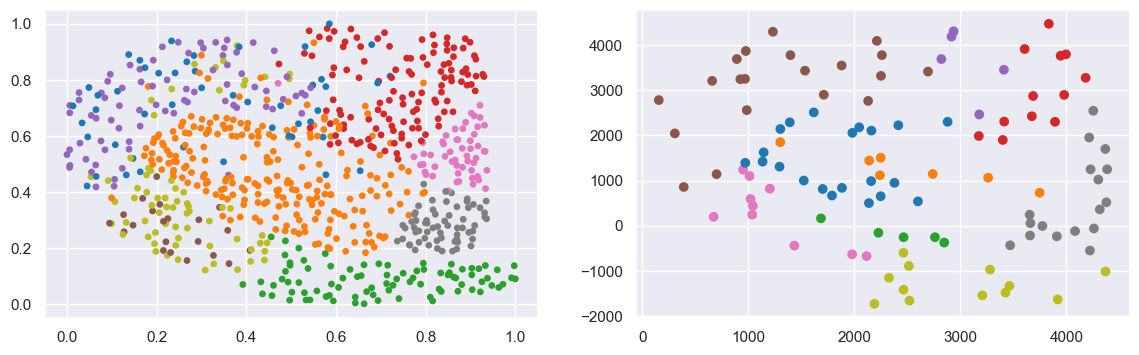

In [9]:
dfscaled = df[['x', 'y', 'cluster']]
dftest1 = dfcluster.copy()
dftest1['res'] = res

dfscaled1 = dfscaled[dfscaled['cluster'].notna()]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']
csmap = {i:c for i,c in enumerate(colors)}

fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].scatter(dftest1['x'], dftest1['y'], c=dftest1['res'].replace(csmap),s=15)
ax[1].scatter(dfscaled1['x'], dfscaled1['y'], c=dfscaled1['cluster'].replace(csmap))

[3]
            x         y  res
97   0.816458  0.960468    3
103  0.892286  0.780822    3
140  0.784104  0.720339    3
163  0.721638  0.574130    1
231  0.766724  0.876537    3
299  0.851819  0.859098    3
446  0.672319  0.587292    3
504  0.829144  0.634475    3
526  0.840732  0.854165    3
595  0.724552  0.635252    3
660  0.781538  0.652997    3
736  0.848039  0.724079    3


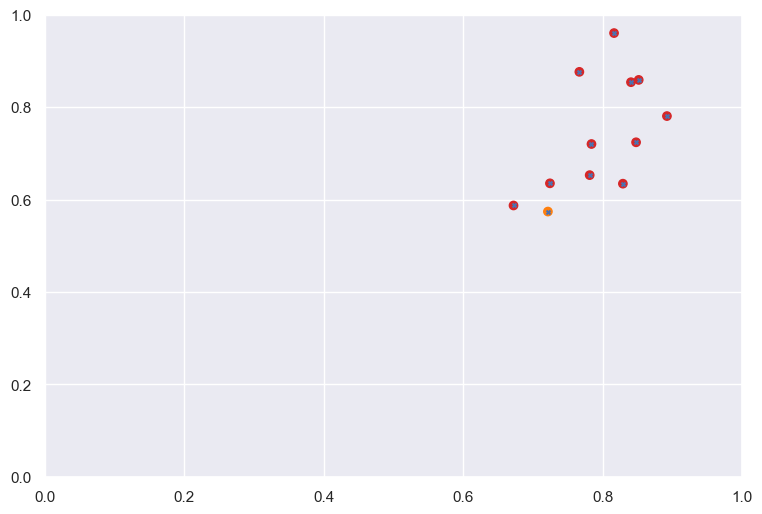

In [10]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']
csmap = {i:c for i,c in enumerate(colors)}

truc = [3]
dftest = dftest1[dfscaled['cluster'].isin(truc)]

for col in ['x','y']:
    dfscaled[col] = normalize(df[col])

plt.figsize = (4,4)
plt.xlim([0, 1])
plt.ylim([0, 1])
print(truc)
print(dftest[['x', 'y', 'res']])
plt.scatter(dftest['x'], dftest['y'], c=dftest['res'].replace(csmap))
plt.scatter(data=dfscaled[dfscaled['cluster'].isin(truc)], x='x', y='y', marker='x', s=8)


# Правило определения кластера

In [11]:
cluster_true_order = (8, 7, 5, 4, 0, 6, 1, 2, 3)
cluster_dict = {}
used_clusters = []
# известный кластер: неизвестный кластер
points = dfres[['name', 'res']].merge(df[['name', 'cluster', 'x', 'y']], how='outer', on='name')

for clust in cluster_true_order:
    piece = points[points['cluster'] == clust]
    if clust in (0,4,5,7,8):
        c = piece.res.value_counts().idxmax()
        cluster_dict[clust] = c
    elif clust == 6:
        c = piece.loc[piece.x == piece.x.min(), 'res'].values[0]
        cluster_dict[clust] = c
    elif clust == 1:
        c = piece.res.value_counts().idxmin()
        cluster_dict[clust] = c
    else:
        nonused_clusters = [i for i in range(9) if i not in used_clusters]
        t = points[points['res'].isin(nonused_clusters)]
        c = t.groupby('res')['y'].min().idxmin()
        cluster_dict[clust] = c
    used_clusters.append(c)
    
cluster_dict_rev = {v:k for k,v in cluster_dict.items()}

In [12]:
dfdict = dfres[['name', 'res']]
dfdict['cluster new'] = dfdict['res'].apply(lambda x: cluster_dict_rev[x])

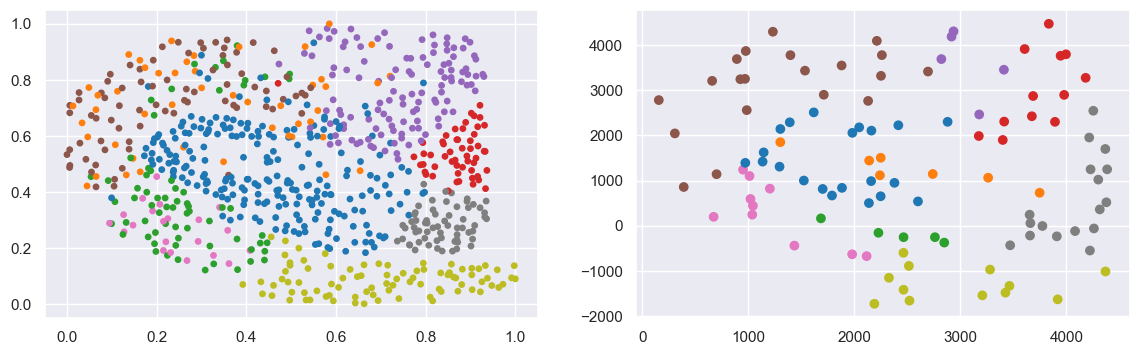

In [13]:
dfscaled = df[['x', 'y', 'cluster']]
dftest1 = dfres.copy()
dftest1 = dftest1.merge(dfdict, how='left', on='name')

dfscaled1 = dfscaled[dfscaled['cluster'].notna()]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']
csmap = {i:c for i,c in enumerate(colors)}

fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].scatter(dftest1['x'], dftest1['y'], c=dftest1['cluster new'].replace(csmap),s=15)
ax[1].scatter(dfscaled1['x'], dfscaled1['y'], c=dfscaled1['cluster'].replace(csmap))

# Привязка точки к кластеру

In [14]:
def get_char_points(i):
    name = df.iloc[i,0]
    x = np.arange(5000)
    data = round(df.iloc[i,3:5003].ewm(alpha=0.1, adjust=False).mean(), 2).tolist()

    coef = np.polyfit(x=x, y=data, deg=2)
    approx = coef[0]*x**2 + coef[1]*x + coef[2]

    errors = pd.Series((data - approx)**2)

    grad_errors = pd.Series(np.absolute(np.gradient(errors))).rolling(6).max()

    char_points = []
    cur = 10000
    row = grad_errors.sort_values(ascending=False)
    for ix, value in zip(row.index, row.values):
        if len(char_points) != 4:
            if value < cur:
                cur = value
                char_points.append(ix)
        else:
            break
    
    char_points.sort()
    char_points = {
        'name': name,
        'p0': char_points[0],
        'p1': char_points[1],
        'p2': char_points[2],
        'p3': char_points[3],
    }
    return char_points
            
arr = []
for i in range(df.shape[0]):
    arr.append(get_char_points(i))
    
points = pd.DataFrame(arr)

# Подготовка файла

In [15]:
df = read_signals('data\\signals.csv')
df[['cluster', 'p0', 'p1', 'p2', 'p3']] = df[['cluster', 'p0', 'p1', 'p2', 'p3']].fillna(-1)
dfmerged = df.merge(points, how='left', on='name', suffixes=['', ' new']).merge(dfdict.drop(columns=['res']), how='left', on='name')

for col in ['cluster', 'p0', 'p1', 'p2', 'p3']:
    for i in range(df.shape[0]):
        if dfmerged.loc[i,col] == -1:
            dfmerged.loc[i,col] = dfmerged.loc[i,col+' new']
            
dfmerged = dfmerged.drop(columns=[col+' new' for col in ['cluster', 'p0', 'p1', 'p2', 'p3']])
dfmerged['cluster'] = dfmerged['cluster'].astype('int')
dfmerged.to_csv('data\\result.csv', index=False)

In [16]:
df.iloc[:,3:5003].mean(axis=1)

0      0.570214
1      0.578640
2      0.593949
3      0.924031
4      0.595756
         ...   
755    0.595806
756    0.929841
757    0.938542
758    0.547134
759    0.796742
Length: 760, dtype: float32